## Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/DL Project/AttackWrappersWhiteBoxP.py" .
!cp "/content/drive/MyDrive/DL Project/DataManagerPytorch.py" .
!cp "/content/drive/MyDrive/DL Project/ResNetPytorch.py" .
from AttackWrappersWhiteBoxP import FGSMNativePytorch, MIMNativePytorch
from ResNetPytorch import resnet56

In [3]:
%pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: re

In [4]:
import os
import math
import numpy as np
import random
import torch
import torchattacks
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision.transforms import Resize
from torchattacks import APGD
from timm import create_model
from tqdm import tqdm

## Device

In [5]:
# Device 설정 (GPU 사용 가능 시 GPU로 설정)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Transform

In [6]:
# Data preprocessing for training
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),                  # Resize images to 224x224
    transforms.RandomCrop(224, padding=4),          # Random crop with padding for augmentation
    transforms.RandomHorizontalFlip(),              # Random horizontal flip
    transforms.ToTensor(),                          # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5),           # Normalize to [-1, 1]
                         (0.5, 0.5, 0.5)),
])

# Data preprocessing for testing
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),                  # Resize images to 224x224
    transforms.ToTensor(),                          # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5),           # Normalize to [-1, 1]
                         (0.5, 0.5, 0.5)),
])

## Dataset

In [7]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

100%|██████████| 170M/170M [00:29<00:00, 5.76MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

## Model

### ViT Model

In [9]:
# ViT 모델 생성
def create_vit_model(model_name, num_classes=10):
    model = create_model(model_name, pretrained=True)  # 사전 학습된 가중치 로드
    model.head = nn.Linear(model.head.in_features, num_classes)  # CIFAR-10 분류 계층 수정
    return model.to(device)

In [ ]:
# Create ViT-B-32 model
model_vit_b32 = create_vit_model('vit_base_patch32_224', num_classes=10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer_b32 = optim.Adam(model_vit_b32.parameters(), lr=0.001)

## Train the model

### Train Function

In [ ]:
# Training function with training and validation metrics
def train_model(model, optimizer, train_loader, val_loader, num_epochs=10):
    model.to(device)
    criterion.to(device)

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_running_loss = 0.0
        train_correct = 0
        train_total = 0

        print(f"Epoch {epoch+1}/{num_epochs}: Training")
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} [Train]")
        for batch_idx, (images, labels) in train_progress:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            train_running_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            # Update progress bar
            train_progress.set_postfix(loss=loss.item())

        # Calculate training metrics
        train_loss = train_running_loss / len(train_loader)
        train_accuracy = 100. * train_correct / train_total

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        print(f"Epoch {epoch+1}/{num_epochs}: Validation")
        with torch.no_grad():
            val_progress = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch {epoch+1} [Val]")
            for batch_idx, (images, labels) in val_progress:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Statistics
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                # Update progress bar
                val_progress.set_postfix(loss=loss.item())

        # Calculate validation metrics
        val_loss = val_running_loss / len(test_loader)
        val_accuracy = 100. * val_correct / val_total

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

### Train ViT-B-32 Model

In [ ]:
model_vit_b32 = model_vit_b32.to(device)

In [ ]:
# ViT-B-16 모델 학습
print("Training ViT-B-32...")
train_model(model_vit_b32, optimizer_b32, train_loader, test_loader, num_epochs=20)

Training ViT-B-32...
Epoch 1/20: Training


Epoch 1 [Train]: 100%|██████████| 782/782 [01:45<00:00,  7.38it/s, loss=1.17]

Epoch 1/20: Validation



Epoch 1 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.24it/s, loss=1.26]

Epoch 1/20 Summary:
  Train Loss: 1.6486, Train Accuracy: 40.34%
  Val Loss: 1.4082, Val Accuracy: 49.24%
--------------------------------------------------
Epoch 2/20: Training



Epoch 2 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.37it/s, loss=1.23]

Epoch 2/20: Validation



Epoch 2 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.29it/s, loss=0.898]

Epoch 2/20 Summary:
  Train Loss: 1.2051, Train Accuracy: 56.06%
  Val Loss: 1.0949, Val Accuracy: 60.48%
--------------------------------------------------
Epoch 3/20: Training



Epoch 3 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.37it/s, loss=1.13]

Epoch 3/20: Validation



Epoch 3 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.17it/s, loss=0.903]

Epoch 3/20 Summary:
  Train Loss: 1.0692, Train Accuracy: 61.70%
  Val Loss: 0.9975, Val Accuracy: 64.56%
--------------------------------------------------
Epoch 4/20: Training



Epoch 4 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.37it/s, loss=1.32]

Epoch 4/20: Validation



Epoch 4 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.09it/s, loss=0.621]

Epoch 4/20 Summary:
  Train Loss: 0.9603, Train Accuracy: 65.67%
  Val Loss: 0.9306, Val Accuracy: 66.69%
--------------------------------------------------
Epoch 5/20: Training



Epoch 5 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.36it/s, loss=0.624]

Epoch 5/20: Validation



Epoch 5 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.20it/s, loss=0.752]

Epoch 5/20 Summary:
  Train Loss: 0.8651, Train Accuracy: 69.23%
  Val Loss: 0.9208, Val Accuracy: 67.48%
--------------------------------------------------
Epoch 6/20: Training



Epoch 6 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.36it/s, loss=0.904]

Epoch 6/20: Validation



Epoch 6 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.17it/s, loss=0.689]

Epoch 6/20 Summary:
  Train Loss: 0.7951, Train Accuracy: 71.64%
  Val Loss: 0.9102, Val Accuracy: 68.14%
--------------------------------------------------
Epoch 7/20: Training



Epoch 7 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.36it/s, loss=0.341]

Epoch 7/20: Validation



Epoch 7 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.25it/s, loss=0.496]

Epoch 7/20 Summary:
  Train Loss: 0.7245, Train Accuracy: 74.31%
  Val Loss: 0.7950, Val Accuracy: 71.92%
--------------------------------------------------
Epoch 8/20: Training



Epoch 8 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.35it/s, loss=1.13]

Epoch 8/20: Validation



Epoch 8 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.13it/s, loss=0.612]

Epoch 8/20 Summary:
  Train Loss: 0.6702, Train Accuracy: 76.46%
  Val Loss: 0.7280, Val Accuracy: 74.21%
--------------------------------------------------
Epoch 9/20: Training



Epoch 9 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.35it/s, loss=1.24]

Epoch 9/20: Validation



Epoch 9 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.09it/s, loss=0.591]

Epoch 9/20 Summary:
  Train Loss: 0.6130, Train Accuracy: 78.24%
  Val Loss: 0.7266, Val Accuracy: 74.31%
--------------------------------------------------
Epoch 10/20: Training



Epoch 10 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.34it/s, loss=0.37]

Epoch 10/20: Validation



Epoch 10 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.14it/s, loss=0.539]

Epoch 10/20 Summary:
  Train Loss: 0.5652, Train Accuracy: 80.10%
  Val Loss: 0.6413, Val Accuracy: 77.85%
--------------------------------------------------
Epoch 11/20: Training



Epoch 11 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.34it/s, loss=0.36]

Epoch 11/20: Validation



Epoch 11 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.12it/s, loss=0.945]

Epoch 11/20 Summary:
  Train Loss: 0.5233, Train Accuracy: 81.45%
  Val Loss: 0.6728, Val Accuracy: 76.67%
--------------------------------------------------
Epoch 12/20: Training



Epoch 12 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.35it/s, loss=0.836]

Epoch 12/20: Validation



Epoch 12 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.13it/s, loss=0.419]

Epoch 12/20 Summary:
  Train Loss: 0.4909, Train Accuracy: 82.64%
  Val Loss: 0.6528, Val Accuracy: 78.04%
--------------------------------------------------
Epoch 13/20: Training



Epoch 13 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.35it/s, loss=0.24]

Epoch 13/20: Validation



Epoch 13 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.13it/s, loss=0.377]

Epoch 13/20 Summary:
  Train Loss: 0.4462, Train Accuracy: 84.34%
  Val Loss: 0.5960, Val Accuracy: 79.41%
--------------------------------------------------
Epoch 14/20: Training



Epoch 14 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.34it/s, loss=0.497]

Epoch 14/20: Validation



Epoch 14 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.19it/s, loss=0.48]

Epoch 14/20 Summary:
  Train Loss: 0.4104, Train Accuracy: 85.65%
  Val Loss: 0.6288, Val Accuracy: 78.98%
--------------------------------------------------
Epoch 15/20: Training



Epoch 15 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.35it/s, loss=0.478]

Epoch 15/20: Validation



Epoch 15 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.02it/s, loss=0.584]

Epoch 15/20 Summary:
  Train Loss: 0.3779, Train Accuracy: 86.59%
  Val Loss: 0.6670, Val Accuracy: 78.21%
--------------------------------------------------
Epoch 16/20: Training



Epoch 16 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.34it/s, loss=0.27]

Epoch 16/20: Validation



Epoch 16 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.11it/s, loss=0.459]

Epoch 16/20 Summary:
  Train Loss: 0.3436, Train Accuracy: 87.70%
  Val Loss: 0.6262, Val Accuracy: 79.76%
--------------------------------------------------
Epoch 17/20: Training



Epoch 17 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.35it/s, loss=0.4]

Epoch 17/20: Validation



Epoch 17 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.03it/s, loss=0.445]

Epoch 17/20 Summary:
  Train Loss: 0.3194, Train Accuracy: 88.75%
  Val Loss: 0.6088, Val Accuracy: 80.80%
--------------------------------------------------
Epoch 18/20: Training



Epoch 18 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.34it/s, loss=0.122]

Epoch 18/20: Validation



Epoch 18 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.17it/s, loss=0.29]

Epoch 18/20 Summary:
  Train Loss: 0.2910, Train Accuracy: 89.63%
  Val Loss: 0.6522, Val Accuracy: 79.93%
--------------------------------------------------
Epoch 19/20: Training



Epoch 19 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.34it/s, loss=0.198]

Epoch 19/20: Validation



Epoch 19 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.18it/s, loss=0.722]

Epoch 19/20 Summary:
  Train Loss: 0.2676, Train Accuracy: 90.55%
  Val Loss: 0.6675, Val Accuracy: 79.70%
--------------------------------------------------
Epoch 20/20: Training



Epoch 20 [Train]: 100%|██████████| 782/782 [01:46<00:00,  7.33it/s, loss=0.0219]

Epoch 20/20: Validation



Epoch 20 [Val]: 100%|██████████| 157/157 [00:09<00:00, 16.17it/s, loss=0.361]

Epoch 20/20 Summary:
  Train Loss: 0.2441, Train Accuracy: 91.15%
  Val Loss: 0.6241, Val Accuracy: 81.18%
--------------------------------------------------


### Evaluate the model

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)  # Get class with highest score
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Calculate overall metrics
    average_loss = running_loss / len(data_loader)
    accuracy = 100. * correct / total
    return average_loss, accuracy

In [ ]:
# ViT-B-32 모델 평가
# Evaluate ViT-B-32 model
print("Evaluating ViT-B-32...")
test_loss, test_accuracy = evaluate_model(model_vit_b32, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Evaluating ViT-B-32...
Test Loss: 0.6241, Test Accuracy: 81.18%


In [ ]:
# 저장 경로 설정
save_dir = '/content/drive/MyDrive/DL Project/'

# 모델 저장
torch.save(model_vit_b32.state_dict(), os.path.join(save_dir, 'vit_b32_cifar10.pth'))

# 저장된 파일 확인
saved_files = os.listdir(save_dir)
print("Saved files:", saved_files)

Saved files: ['Baseline Model.ipynb', 'vit_b32_cifar10.pth', 'vit_b16_cifar10.pth', 'ViT-B Model.ipynb']


### Load the model

#### CUDA

In [10]:
# 저장 경로 설정
save_dir = '/content/drive/MyDrive/DL Project/'

# 모델 정의
model_vit_b32 = create_vit_model('vit_base_patch32_224', num_classes=10)

# 가중치 로드
model_vit_b32.load_state_dict(torch.load(os.path.join(save_dir, 'vit_b32_cifar10.pth')))

# 모델을 올바른 장치로 이동
model_vit_b32 = model_vit_b32.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

<ipython-input-10-1c82c1469d14>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vit_b32.load_state_dict(torch.load(os.path.join(save_dir, 'vit_b32_cifar10.pth')))


#### CPU

In [ ]:
# Set save directory
save_dir = '/content/drive/MyDrive/DL Project/'

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
model_vit_b32 = create_vit_model('vit_base_patch32_224', num_classes=10)

# Load weights with proper mapping
model_vit_b32.load_state_dict(
    torch.load(os.path.join(save_dir, 'vit_b32_cifar10.pth'), map_location=device)
)

# Move model to the correct device
model_vit_b32 = model_vit_b32.to(device)

print("Model successfully loaded and moved to device:", device)

### Resize 32 x 32

In [ ]:
def interpolate_positional_embeddings(model, new_img_size, patch_size=32):
    # 기존 Positional Embedding 가져오기
    old_pos_embed = model.pos_embed.detach()  # Shape: [1, num_patches + 1, embed_dim]
    cls_token = old_pos_embed[:, :1, :]  # CLS 토큰
    patch_pos_embed = old_pos_embed[:, 1:, :]  # 패치 위치 임베딩

    # 기존 패치 크기 계산
    old_grid_size = int((patch_pos_embed.size(1))**0.5)
    new_grid_size = new_img_size // patch_size

    # 위치 임베딩 Reshape 및 Interpolation
    patch_pos_embed = patch_pos_embed.reshape(1, old_grid_size, old_grid_size, -1).permute(0, 3, 1, 2)
    new_pos_embed = torch.nn.functional.interpolate(
        patch_pos_embed,
        size=(new_grid_size, new_grid_size),
        mode="bilinear"
    ).permute(0, 2, 3, 1).reshape(1, -1, patch_pos_embed.size(1))

    # CLS 토큰과 새로운 위치 임베딩 결합
    new_pos_embed = torch.cat([cls_token, new_pos_embed], dim=1)
    model.pos_embed = torch.nn.Parameter(new_pos_embed)

In [ ]:
# Positional Embedding 업데이트
interpolate_positional_embeddings(model_vit_b32, new_img_size=32, patch_size=32)
print("Positional embeddings updated for 32x32 input.")

Positional embeddings updated for 32x32 input.


In [ ]:
# PatchEmbed 수정
model_vit_b32.patch_embed.img_size = (32, 32)  # 새로운 이미지 크기
model_vit_b32.patch_embed.num_patches = (32 // 32) * (32 // 32)  # 1 패치로 변경
print("Patch embedding updated for 32x32 input.")

Patch embedding updated for 32x32 input.


In [ ]:
# 데이터 전처리 수정
transform_test_32 = transforms.Compose([
    transforms.Resize((32, 32)),  # 32x32 크기로 리사이즈
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# 데이터셋 로드
test_dataset_32 = datasets.CIFAR10(root='./data', train=False, transform=transform_test_32, download=True)
test_loader_32 = DataLoader(test_dataset_32, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
# ViT-B-32 모델 평가
# Evaluate ViT-B-32 model
print("Evaluating ViT-B-32...")
test_loss, test_accuracy = evaluate_model(model_vit_b32, test_loader_32, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Evaluating ViT-B-32...
Test Loss: 4.8469, Test Accuracy: 16.54%


## Whitebox

### Evaluate whitebox attack model

In [11]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy:.2f}%')
    return accuracy

### Fast Gradient Sign Method (FGSM)

In [ ]:
model_vit_b32 = model_vit_b32.to(device)

In [ ]:
# FGSM
epsilon = 0.031  # Perturbation magnitude
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using FGSMNativePytorch
adv_loader_FGSM = FGSMNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model_vit_b32,
    epsilonMax=epsilon,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

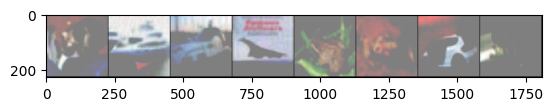

In [ ]:
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_FGSM:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5  # Assuming CIFAR-10 normalization

# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [ ]:
evaluate(model_vit_b32, adv_loader_FGSM)

Accuracy on adversarial examples: 17.44%


17.44

### Momentum Iterative Method (MIM)

In [ ]:
# MIM
# Define parameters
epsilon = 0.031  # Maximum perturbation magnitude
epsilon_step = 0.00155  # Step size for each iteration
num_steps = 10  # Number of attack iterations
decay_factor = 1.0  # Momentum decay factor
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using MIMNativePytorch
adv_loader_MIM = MIMNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model_vit_b32,
    decayFactor=decay_factor,
    epsilonMax=epsilon,
    epsilonStep=epsilon_step,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

Processing up to sample= 64
Processing up to sample= 128
Processing up to sample= 192
Processing up to sample= 256
Processing up to sample= 320
Processing up to sample= 384
Processing up to sample= 448
Processing up to sample= 512
Processing up to sample= 576
Processing up to sample= 640
Processing up to sample= 704
Processing up to sample= 768
Processing up to sample= 832
Processing up to sample= 896
Processing up to sample= 960
Processing up to sample= 1024
Processing up to sample= 1088
Processing up to sample= 1152
Processing up to sample= 1216
Processing up to sample= 1280
Processing up to sample= 1344
Processing up to sample= 1408
Processing up to sample= 1472
Processing up to sample= 1536
Processing up to sample= 1600
Processing up to sample= 1664
Processing up to sample= 1728
Processing up to sample= 1792
Processing up to sample= 1856
Processing up to sample= 1920
Processing up to sample= 1984
Processing up to sample= 2048
Processing up to sample= 2112
Processing up to sample= 2

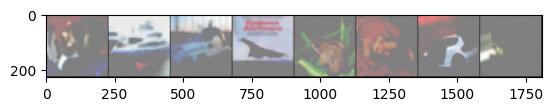

In [ ]:
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_MIM:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5
# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [ ]:
evaluate(model_vit_b32, adv_loader_MIM)

Accuracy on adversarial examples: 2.14%


2.14

### Projected Gradient Descent (PGD)

In [ ]:
def PGDNativePytorch(device, dataLoader, model, epsilonMax, epsilonStep, numSteps, clipMin, clipMax, targeted):
    model.eval()  # Set model to evaluation mode
    # Generate variables for storing the adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]  # Get input shape from DataLoader
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)

    advSampleIndex = 0
    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        batchSize = xData.shape[0]
        advImages = xData.clone().detach()

        # PGD iterations
        for _ in range(numSteps):
            advImages.requires_grad = True
            outputs = model(advImages)
            loss = torch.nn.CrossEntropyLoss()(outputs, yData)
            model.zero_grad()
            loss.backward()

            # Generate adversarial perturbations
            gradSign = advImages.grad.sign()
            if targeted:
                advImages = advImages - epsilonStep * gradSign  # Targeted: decrease towards target
            else:
                advImages = advImages + epsilonStep * gradSign  # Untargeted: increase loss

            # Project adversarial examples to epsilon-ball and clip to valid range
            advImages = torch.clamp(advImages, xData - epsilonMax, xData + epsilonMax)
            advImages = torch.clamp(advImages, clipMin, clipMax).detach()

        # Save adversarial examples
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j].cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return DataLoader with adversarial examples
    advLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [ ]:
# Define PGD parameters
epsilon = 0.031  # Maximum perturbation magnitude
epsilon_step = 0.00155  # Step size
num_steps = 20  # Number of attack iterations
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using PGD
adv_loader_PGD = PGDNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model_vit_b32,
    epsilonMax=epsilon,
    epsilonStep=epsilon_step,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

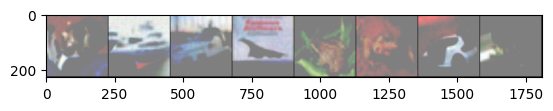

In [ ]:
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_PGD:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5
# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [ ]:
evaluate(model_vit_b32, adv_loader_PGD)

Accuracy on adversarial examples: 0.37%


0.37

### Auto Projected Gradient Descent (APGD)

In [ ]:
def APGDNativePytorch(
    device, dataLoader, model, epsilonMax, numSteps, clipMin, clipMax, restarts=1, rho=0.75, max_queries=5000
):
    """
    Implements the APGD attack with parameters specified in the paper.

    Args:
        device (torch.device): Device for computations.
        dataLoader (DataLoader): DataLoader for clean test images.
        model (nn.Module): Target model.
        epsilonMax (float): Maximum perturbation magnitude.
        numSteps (int): Number of attack iterations.
        clipMin (float): Minimum pixel value.
        clipMax (float): Maximum pixel value.
        restarts (int): Number of restarts (default: 1).
        rho (float): Early stopping threshold (default: 0.75).
        max_queries (int): Maximum number of queries per sample (default: 5000).

    Returns:
        DataLoader: DataLoader containing adversarial examples and their true labels.
    """
    model.eval()
    attack = APGD(model, eps=epsilonMax, steps=numSteps, n_restarts=restarts)

    # Store adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)

    advSampleIndex = 0
    query_count = 0

    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)

        # Early stopping mechanism based on ρ and max_queries
        for restart in range(restarts):
            if query_count >= max_queries:
                break  # Stop if query budget is reached

            advImages = attack(xData, yData)

            # Update query count
            query_count += xData.size(0)

            # Check if early stopping conditions (ρ) are satisfied
            outputs = model(advImages)
            _, preds = outputs.max(1)
            success_rate = ((preds != yData).sum().item()) / yData.size(0)

            if success_rate >= rho:
                break  # Early stopping if success rate reaches threshold

        # Save adversarial examples
        batchSize = xData.shape[0]
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j].cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return DataLoader with adversarial examples
    advLoader = DataLoader(
        TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [ ]:
# Parameters for APGD from the paper
epsilon = 0.031
num_steps = 10
restarts = 1
rho = 0.75
max_queries = 5000
clip_min = 0.0
clip_max = 1.0

In [ ]:
# Generate adversarial examples using APGD
adv_loader_APGD = APGDNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model_vit_b32,
    epsilonMax=epsilon,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    restarts=restarts,
    rho=rho,
    max_queries=max_queries
)

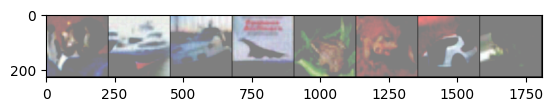

In [ ]:
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_APGD:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5
# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [ ]:
evaluate(model_vit_b32, adv_loader_APGD)

Accuracy on adversarial examples: 4.80%


4.8

## Additional White-box Attacks

### Backward Pass Differentiable Approximation (BPDA)

In [ ]:
def BPDANativePytorch(device, dataLoader, model, epsilonMax, epsilonStep, numSteps, clipMin, clipMax):
    model.eval()  # Set the model to evaluation mode

    # Initialize variables to store adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]  # Get the input shape from DataLoader
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)
    advSampleIndex = 0

    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        batchSize = xData.size(0)
        advImages = xData.clone().detach()

        # BPDA iterations
        for _ in range(numSteps):
            advImages.requires_grad = True

            # Forward pass through the model (with a differentiable approximation if needed)
            outputs = model(advImages)

            # Define a loss function (e.g., CrossEntropyLoss)
            loss = torch.nn.CrossEntropyLoss()(outputs, yData)

            # Zero all gradients, compute gradients, and update adversarial examples
            model.zero_grad()
            loss.backward()

            # Approximate gradients of non-differentiable operations here if applicable
            gradSign = advImages.grad.sign()
            advImages = advImages + epsilonStep * gradSign
            advImages = torch.clamp(advImages, xData - epsilonMax, xData + epsilonMax)  # Epsilon-ball projection
            advImages = torch.clamp(advImages, clipMin, clipMax).detach()  # Clip to valid range

        # Save adversarial examples
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j].cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return a DataLoader with adversarial examples
    advLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [ ]:
# BPDA parameters
epsilon = 0.031  # Maximum perturbation magnitude
epsilon_step = 0.01  # Step size
num_steps = 10  # Number of iterations
clip_min = 0.0
clip_max = 1.0

# Generate BPDA adversarial examples
adv_loader_BPDA = BPDANativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model_vit_b32,
    epsilonMax=epsilon,
    epsilonStep=epsilon_step,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max
)

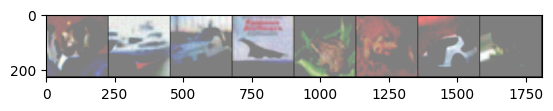

In [ ]:
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_BPDA:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5
# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [ ]:
evaluate(model_vit_b32, adv_loader_BPDA)

Accuracy on adversarial examples: 0.36%


0.36

### Carlini and Wagner (C&W)

In [ ]:
def CWPytorch(device, dataLoader, model, c=1.0, kappa=0, numSteps=1000, lr=0.01, clipMin=0.0, clipMax=1.0):
    model.eval()  # Set the model to evaluation mode

    # Initialize variables to store adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]  # Get input shape from DataLoader
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)
    advSampleIndex = 0

    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        batchSize = xData.size(0)

        # Initialize adversarial perturbation
        delta = torch.zeros_like(xData, requires_grad=True).to(device)

        # Define optimizer for delta
        optimizer = optim.Adam([delta], lr=lr)

        for _ in range(numSteps):
            advImages = torch.clamp(xData + delta, clipMin, clipMax)  # Add perturbation and clip to valid range

            # Forward pass
            outputs = model(advImages)

            # Define C&W loss function
            real = outputs.gather(1, yData.view(-1, 1)).squeeze()  # Correct class scores
            one_hot = torch.eye(outputs.size(1), device=device)[yData]
            other = torch.max((outputs - one_hot * 1e4), dim=1)[0]  # Max of incorrect class scores
            f = torch.clamp(real - other + kappa, min=0)  # Confidence margin

            l2_norm = torch.sum(delta ** 2)
            loss = l2_norm + c * torch.sum(f)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Save adversarial examples
        for j in range(batchSize):
            xAdv[advSampleIndex] = torch.clamp(xData[j] + delta[j], clipMin, clipMax).cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return a DataLoader with adversarial examples
    advLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [ ]:
# C&W parameters
c = 1.0  # Regularization constant
kappa = 0  # Confidence margin
num_steps = 100  # Number of iterations
lr = 0.01  # Learning rate
clip_min = 0.0
clip_max = 1.0

# Generate C&W adversarial examples
adv_loader_CW = CWPytorch(
    device=device,
    dataLoader=test_loader,
    model=model_vit_b32,
    c=c,
    kappa=kappa,
    numSteps=num_steps,
    lr=lr,
    clipMin=clip_min,
    clipMax=clip_max
)

In [ ]:
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_CW:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5
# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [ ]:
evaluate(model_vit_b32, adv_loader_CW)

Accuracy on adversarial examples: 26.48%


26.48

## Transferaibility

### Load the Resnet56

In [12]:
# Define the path to the weights
save_dir = '/content/drive/MyDrive/DL Project/'
weight_path = os.path.join(save_dir, 'resnet56_cifar10_2.pth')

model_resnet = resnet56(inputImageSize=32, numClasses=10).to(device)

# Load the weights
model_resnet.load_state_dict(torch.load(weight_path))

# Move the model to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet = model_resnet.to(device)

print("ResNet56 weights loaded successfully!")

<ipython-input-12-9e44ae761b55>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resnet.load_state_dict(torch.load(weight_path))


ResNet56 weights loaded successfully!


In [13]:
# Loss function
criterion_res = nn.CrossEntropyLoss()

# Optimizer
optimizer_res = optim.SGD(model_resnet.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

### Resnet56 Model Dataset Setup

In [14]:
# Define transformations for ViT
res_transform_train = transforms.Compose([
    transforms.Resize(32),  # Resize to 224x224 for ViT
    transforms.RandomCrop(224, padding=4),  # Optional data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

res_transform_test = transforms.Compose([
    transforms.Resize(32),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset with ViT transformations
res_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=res_transform_train)
res_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=res_transform_test)

# Create DataLoaders for ViT
res_train_loader = DataLoader(res_train_dataset, batch_size=64, shuffle=True, num_workers=2)
res_test_loader = DataLoader(res_test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

In [16]:
# Evaluate the ViT model on resized CIFAR-10 test data
test_loss, test_acc = validate(model_resnet, res_test_loader, criterion_res, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

/content/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Test Loss: 1.6941, Test Accuracy: 77.25%


### Define Resizing and Evaluation

In [17]:
# Function to resize adversarial examples
def resize_adv_loader(adv_loader, target_size, device):
    """
    Resize adversarial examples to match the target model's input size.

    Args:
        adv_loader (DataLoader): DataLoader containing adversarial examples and labels.
        target_size (tuple): Target size (height, width) for resizing.
        device (torch.device): Device for computations.

    Returns:
        DataLoader: DataLoader with resized adversarial examples.
    """
    resized_images = []
    resized_labels = []

    for images, labels in adv_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Resize images
        resized = torch.nn.functional.interpolate(images, size=target_size, mode='bilinear', align_corners=False)
        resized_images.append(resized.cpu())
        resized_labels.append(labels.cpu())

    # Concatenate resized images and labels
    resized_images = torch.cat(resized_images)
    resized_labels = torch.cat(resized_labels)

    # Create a new DataLoader
    dataset = TensorDataset(resized_images, resized_labels)
    resized_loader = DataLoader(dataset, batch_size=adv_loader.batch_size, shuffle=False)

    return resized_loader

In [18]:
# Function to evaluate transferability
def evaluate_transferability(target_model, adv_loader, device):
    """
    Evaluate transferability of adversarial examples on the target model.

    Args:
        target_model (nn.Module): The target model (e.g., ViT-B-32).
        adv_loader (DataLoader): DataLoader containing adversarial examples and their true labels.
        device (torch.device): Device for computations.

    Returns:
        float: Transferability success rate (% of adversarial examples that are misclassified).
    """
    target_model.eval()
    correct = 0
    total = 0

    for adv_images, labels in adv_loader:
        adv_images, labels = adv_images.to(device), labels.to(device)

        # Test adversarial examples on the target model
        outputs = target_model(adv_images)
        _, predicted = outputs.max(1)

        # Count correctly classified examples
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    transfer_success_rate = 100.0 * (1 - correct / total)
    print(f"Transferability Success Rate: {transfer_success_rate:.2f}%")
    return transfer_success_rate

### Fast Gradient Sign Method (FGSM)

In [ ]:
adv_loader_resized_fgsm = resize_adv_loader(adv_loader_FGSM, target_size=(32, 32), device=device)

In [ ]:
transfer_success_rate = evaluate_transferability(
    target_model=model_resnet,
    adv_loader=adv_loader_resized_fgsm,
    device=device
)

Transferability Success Rate: 81.47%


### Momentum Iterative Method (MIM)

In [ ]:
# MIM
adv_loader_resized_mim = resize_adv_loader(adv_loader_MIM, target_size=(32, 32), device=device)

In [ ]:
transfer_success_rate_MIM = evaluate_transferability(
    target_model=model_resnet,
    adv_loader=adv_loader_resized_mim,
    device=device
)

Transferability Success Rate: 67.55%


### Projected Gradient Descent (PGD)

In [ ]:
adv_loader_resized_pgd = resize_adv_loader(adv_loader_PGD, target_size=(32, 32), device=device)

In [ ]:
transfer_success_rate_PGD = evaluate_transferability(
    target_model=model_resnet,
    adv_loader=adv_loader_resized_pgd,
    device=device
)

/content/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Transferability Success Rate: 68.78%


### Auto Projected Gradient Descent (APGD)

In [ ]:
adv_loader_resized_apgd = resize_adv_loader(adv_loader_APGD, target_size=(32, 32), device=device)

In [ ]:
transfer_success_rate = evaluate_transferability(
    target_model=model_resnet,
    adv_loader=adv_loader_resized_apgd,
    device=device
)

/content/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Transferability Success Rate: 76.24%


## Blackbox Attacks

### RayS Attack

In [40]:
def RaySAttack(model, images, labels, epsilon, query_budget, device):
    model.eval()  # Ensure the model is in evaluation mode

    # Ensure images and labels are on the correct device
    images = images.to(device)
    labels = labels.to(device)

    batch_size = images.size(0)
    perturbations = torch.zeros_like(images, device=device)

    # Initial random directions (ensure they are on the correct device)
    directions = torch.randn_like(images).sign().to(device)

    for query_count in range(query_budget):
        # Positive and negative perturbations
        pos_images = torch.clamp(images + perturbations + epsilon * directions, 0, 1)
        neg_images = torch.clamp(images + perturbations - epsilon * directions, 0, 1)

        # Query the model
        pos_outputs = model(pos_images)
        neg_outputs = model(neg_images)

        # Get predictions
        _, pos_preds = pos_outputs.max(1)
        _, neg_preds = neg_outputs.max(1)

        # Update perturbations based on misclassification
        pos_misclassified = pos_preds != labels
        neg_misclassified = neg_preds != labels

        perturbations[pos_misclassified] += epsilon * directions[pos_misclassified]
        perturbations[neg_misclassified] -= epsilon * directions[neg_misclassified]

        # Stop if all images are misclassified
        if pos_misclassified.sum() + neg_misclassified.sum() == batch_size:
            break

    # Apply the final perturbations
    adversarial_examples = torch.clamp(images + perturbations, 0, 1)
    return adversarial_examples

In [46]:
def generate_rays_adv_loader(model, data_loader, epsilon, query_budget, device):
    model.eval()

    adv_images_list = []
    labels_list = []

    # Wrap data_loader with tqdm to track progress
    for images, labels in tqdm(data_loader, desc="Generating Adversarial Examples"):
        images, labels = images.to(device), labels.to(device)

        batch_adv_images = []
        for i in range(images.size(0)):
            # Run RaySAttack on a single image
            adv_image = RaySAttack(
                model=model,
                images=images[i:i+1],  # Single image
                labels=labels[i:i+1],
                epsilon=epsilon,
                query_budget=query_budget,
                device=device
            )
            batch_adv_images.append(adv_image)

        # Concatenate adversarial examples for the batch
        adv_images_list.append(torch.cat(batch_adv_images, dim=0).cpu())
        labels_list.append(labels.cpu())

    # Concatenate all adversarial examples and labels
    adv_images_all = torch.cat(adv_images_list, dim=0)
    labels_all = torch.cat(labels_list, dim=0)

    # Create a new DataLoader for adversarial examples
    adv_dataset = TensorDataset(adv_images_all, labels_all)
    adv_loader = DataLoader(adv_dataset, batch_size=data_loader.batch_size, shuffle=False)

    return adv_loader

In [50]:
def generate_rays_adv_loader(model, data_loader, epsilon, query_budget, device):
    model.eval()

    adv_images_list = []
    labels_list = []

    for batch_idx, (images, labels) in enumerate(tqdm(data_loader, desc="Generating Adversarial Examples")):
        print(f"Batch {batch_idx + 1}/{len(data_loader)} started.")

        # Ensure images and labels are on the correct device
        images, labels = images.to(device), labels.to(device)

        # Initialize the list for storing adversarial examples of the current batch
        batch_adv_images = []

        for i in range(images.size(0)):
            try:
                adv_image = RaySAttack(
                    model=model,
                    images=images[i:i+1],  # Single image
                    labels=labels[i:i+1],
                    epsilon=epsilon,
                    query_budget=query_budget,
                    device=device
                )

                if adv_image is not None:
                    print(f"[INFO] Adversarial example generated for image {i + 1}/{images.size(0)}: Shape {adv_image.shape}")
                    batch_adv_images.append(adv_image)
                else:
                    print(f"[WARNING] No adversarial example generated for image {i + 1}/{images.size(0)}.")
            except Exception as e:
                print(f"[ERROR] Failed to generate adversarial example for image {i + 1}/{images.size(0)}: {e}")

        # Check and log the number of adversarial examples generated
        print(f"Batch adversarial images length: {len(batch_adv_images)}")
        if len(batch_adv_images) > 0:
            adv_images_list.append(torch.cat(batch_adv_images, dim=0).cpu())
            labels_list.append(labels.cpu())
        else:
            print(f"[WARNING] No adversarial examples generated for batch {batch_idx + 1}.")

    # Final concatenation of all adversarial examples and labels
    if len(adv_images_list) == 0 or len(labels_list) == 0:
        raise RuntimeError("No adversarial examples were generated for any batch.")

    adv_images_all = torch.cat(adv_images_list, dim=0)
    labels_all = torch.cat(labels_list, dim=0)

    # Create a new DataLoader for adversarial examples
    adv_dataset = TensorDataset(adv_images_all, labels_all)
    adv_loader = DataLoader(adv_dataset, batch_size=data_loader.batch_size, shuffle=False)

    return adv_loader

In [51]:
def create_subset(dataset, subset_percentage, seed=None):
    """
    Create a subset of a dataset based on a specified percentage.

    Args:
        dataset (torch.utils.data.Dataset): The full dataset.
        subset_percentage (float): The percentage of the dataset to use (e.g., 0.1 for 10%).
        seed (int, optional): Seed for reproducibility. Default is None.

    Returns:
        Subset: A subset of the dataset.
    """
    if seed is not None:
        np.random.seed(seed)  # Set the seed for reproducibility

    total_samples = len(dataset)
    subset_size = int(total_samples * subset_percentage)

    # Generate random indices for the subset
    subset_indices = np.random.choice(range(total_samples), subset_size, replace=False)

    # Create a subset dataset
    return Subset(dataset, subset_indices)

In [52]:
subset_indices = np.random.choice(len(test_dataset), size=1000, replace=False)
test_subset = Subset(test_dataset, subset_indices)
test_loader_subset = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

In [56]:
# Parameters for RayS attack
epsilon = 0.031
query_budget = 100

# Generate adversarial examples for the entire test dataset
adv_loader_RayS = generate_rays_adv_loader(model=model_vit_b32, data_loader=test_loader_subset, epsilon=epsilon, query_budget=query_budget, device=device)

Generating Adversarial Examples:   0%|          | 0/16 [00:00<?, ?it/s]

Batch 1/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 11/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adv

Generating Adversarial Examples:   6%|▋         | 1/16 [01:27<21:50, 87.35s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 2/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape tor

Generating Adversarial Examples:  12%|█▎        | 2/16 [03:00<21:09, 90.66s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 3/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape tor

Generating Adversarial Examples:  19%|█▉        | 3/16 [04:32<19:50, 91.56s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 4/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape tor

Generating Adversarial Examples:  25%|██▌       | 4/16 [06:04<18:18, 91.53s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 5/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape tor

Generating Adversarial Examples:  31%|███▏      | 5/16 [07:37<16:53, 92.13s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 6/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape tor

Generating Adversarial Examples:  38%|███▊      | 6/16 [09:09<15:19, 91.99s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 7/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape tor

Generating Adversarial Examples:  44%|████▍     | 7/16 [10:38<13:38, 90.93s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 8/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape tor

Generating Adversarial Examples:  50%|█████     | 8/16 [12:06<12:01, 90.24s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 9/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape tor

Generating Adversarial Examples:  56%|█████▋    | 9/16 [13:35<10:27, 89.62s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 10/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape to

Generating Adversarial Examples:  62%|██████▎   | 10/16 [15:07<09:03, 90.51s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 11/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape to

Generating Adversarial Examples:  69%|██████▉   | 11/16 [16:38<07:33, 90.66s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 12/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape to

Generating Adversarial Examples:  75%|███████▌  | 12/16 [18:11<06:05, 91.38s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 13/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape to

Generating Adversarial Examples:  81%|████████▏ | 13/16 [19:44<04:35, 91.73s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 14/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape to

Generating Adversarial Examples:  88%|████████▊ | 14/16 [21:15<03:03, 91.60s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 15/16 started.
[INFO] Adversarial example generated for image 1/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/64: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/64: Shape to

Generating Adversarial Examples:  94%|█████████▍| 15/16 [22:46<01:31, 91.50s/it]

[INFO] Adversarial example generated for image 64/64: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 64
Batch 16/16 started.
[INFO] Adversarial example generated for image 1/40: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 2/40: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 3/40: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 4/40: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 5/40: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 6/40: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 7/40: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 8/40: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 9/40: Shape torch.Size([1, 3, 224, 224])
[INFO] Adversarial example generated for image 10/40: Shape to

Generating Adversarial Examples: 100%|██████████| 16/16 [23:43<00:00, 88.96s/it]

[INFO] Adversarial example generated for image 40/40: Shape torch.Size([1, 3, 224, 224])
Batch adversarial images length: 40


In [57]:
# Evaluate the target model on these adversarial examples
evaluate(model_vit_b32, adv_loader_RayS)

Accuracy on adversarial examples: 43.70%


43.7

### Blackbox Transferability

In [62]:
adv_loader_resized_rays = resize_adv_loader(adv_loader_RayS, target_size=(32, 32), device=device)

In [63]:
def test_transferability(target_model, adv_loader, device):
    """
    Test transferability using pre-generated adversarial examples.

    Args:
        target_model (nn.Module): The model being evaluated for transferability (e.g., ViT or ResNet).
        adv_loader (DataLoader): DataLoader containing adversarial examples and their true labels.
        device (torch.device): Device to run the computations on.

    Returns:
        float: Transferability rate (% of adversarial examples misclassified by the target model).
    """
    target_model.eval()  # Set the target model to evaluation mode

    transfer_correct = 0
    transfer_total = 0

    for adv_images, labels in adv_loader:
        adv_images, labels = adv_images.to(device), labels.to(device)

        # Test adversarial examples on the target model
        outputs = target_model(adv_images)
        _, predicted = outputs.max(1)

        # Count correctly classified adversarial examples
        transfer_total += labels.size(0)
        transfer_correct += (predicted == labels).sum().item()

    # Calculate transferability rate
    transferability_rate = 100.0 * (1 - transfer_correct / transfer_total)
    return transferability_rate

In [64]:
# Test transferability of adversarial examples from ResNet-56 to ViT-32
transfer_rate = test_transferability(
    target_model=model_resnet,          # ViT-32 as the target model
    adv_loader=adv_loader_resized_rays,  # Adversarial examples generated by ResNet-56
    device=device
)

print(f"Transferability from ResNet-56 to ViT-32: {transfer_rate:.2f}%")

Transferability from ResNet-56 to ViT-32: 64.80%


/content/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))
